##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 图像分类

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/tutorials/images/classification"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/classification.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/images/classification.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/images/classification.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

本教程展示了如何使用 `tf.keras.Sequential` 模型对花卉图像进行分类，并使用 `tf.keras.utils.image_dataset_from_directory` 加载数据。其中演示了以下概念：

- 从磁盘高效加载数据集。
- 识别过拟合，并应用数据增强和随机失活等技术缓解过拟合。

本教程遵循基本的机器学习工作流：

1. 检查并理解数据
2. 构建输入流水线
3. 构建模型
4. 训练模型
5. 测试模型
6. 改进模型并重复整个过程

此外，该笔记本还演示了如何将[保存的模型](../../../guide/saved_model.ipynb)转换为 [TensorFlow Lite](https://tensorflow.google.cn/lite/) 模型，以便在移动设备、嵌入式设备和 IoT 设备上进行设备端机器学习。

## 设置

导入 TensorFlow 和其他必要的库：

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 下载并探索数据集

本教程使用一个包含约 3,700 张花卉照片的数据集。该数据集包含 5 个子目录，每个子目录对应一个类：

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [2]:
import pathlib

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path('../data/flower_photos/').with_suffix('')

下载后，您现在应该拥有一个数据集的副本。总共有 3,670 个图像：

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


下面是一些玫瑰：

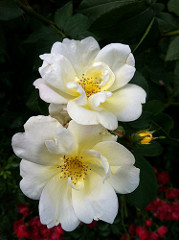

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

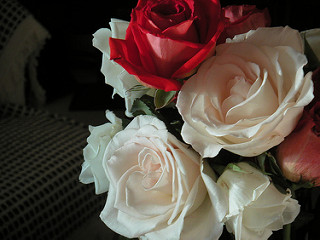

In [5]:
PIL.Image.open(str(roses[1]))

和一些郁金香：

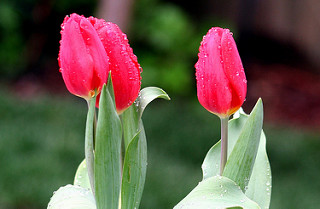

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

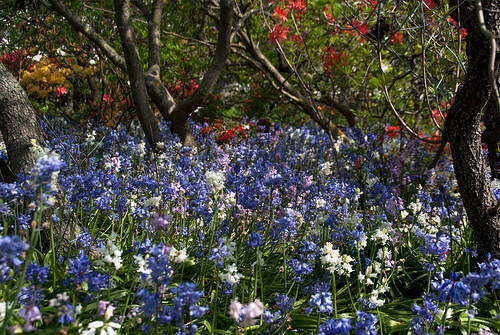

In [7]:
PIL.Image.open(str(tulips[1]))

## 使用 Keras 效用函数加载数据

接下来，使用有用的 `tf.keras.utils.image_dataset_from_directory` 实用工具从磁盘上加载这些图像。只需几行代码就能将磁盘上的图像目录转移到 `tf.data.Dataset`。如果愿意，您也可以访问[加载和预处理图像](../load_data/images.ipynb)教程，从头开始编写您自己的数据加载代码。

### 创建数据集

为加载程序定义一些参数：

In [8]:
batch_size = 32
img_height = 180
img_width = 180

开发模型时，使用验证拆分是一种很好的做法。将 80% 的图像用于训练，将 20% 的图像用于验证。

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


您可以在这些数据集的 `class_names` 特性中找到类名称。这些名称按照字母顺序与目录名称相对应。

In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 呈现数据

下面是训练数据集中的前 9 个图像：

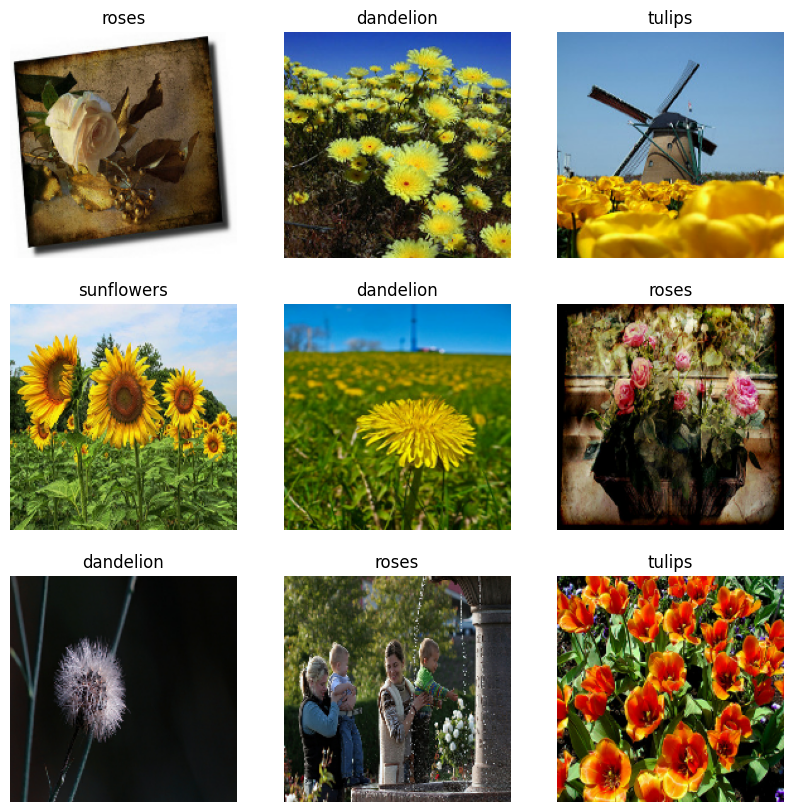

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

您将把这些数据集传递给 Keras `Model.fit` 方法，以便在本教程的后面部分进行训练。如果愿意，您还可以手动迭代数据集并检索批量图像：

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch` 是形状为 `(32, 180, 180, 3)` 的张量。这是由 32 个形状为 `180x180x3`（最后一个维度是指颜色通道 RGB）的图像组成的批次。`label_batch` 是形状为 `(32,)` 的张量，这些是 32 个图像的对应标签。

您可以在 `image_batch` 和 `labels_batch` 张量上调用 `.numpy()`，将其转换为 `numpy.ndarray`。


## 配置数据集以提高性能

请确保使用缓冲预提取，以便从磁盘产生数据，而不会阻塞 I/O。这是您在加载数据时应该使用的两种重要方法。

- 在第一个周期期间从磁盘加载图像后，`Dataset.cache()` 会将这些图像保留在内存中。这将确保在训练模型时数据集不会成为瓶颈。如果数据集太大无法装入内存，您也可以使用此方法创建高性能的磁盘缓存。
- `Dataset.prefetch()` 会在训练时将数据预处理和模型执行重叠。

感兴趣的读者可以在[使用 tf.data API 获得更佳性能](../../guide/data_performance.ipynb)指南的*预提取*部分了解更多有关这两种方法的详细信息，以及如何将数据缓存到磁盘。

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 标准化数据

RGB 通道值在 `[0, 255]` 范围内。这对于神经网络来说并不理想；一般而言，您应当设法使您的输入值变小。

在这里，我们通过使用 `tf.keras.layers.Rescaling` 将值标准化为在 `[0, 1]` 范围内。

In [15]:
normalization_layer = layers.Rescaling(1./255)

可以通过两种方式使用该层。您可以通过调用 `Dataset.map` 将其应用于数据集：

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9891067


或者，您可以在模型定义中包括该层，从而简化部署。在这里，请使用第二种方式。

注：您之前使用 `tf.keras.utils.image_dataset_from_directory` 的 `image_size` 参数调整了图像大小。如果您还希望在模型中包括调整大小的逻辑，可以使用 `tf.keras.layers.Resizing` 层。

## 基本 Keras 模型

### 创建模型

Keras [序贯](https://tensorflow.google.cn/guide/keras/sequential_model)模型由三个卷积块 (`tf.keras.layers.Conv2D`) 组成，每个卷积块都有一个最大池化层 (`tf.keras.layers.MaxPooling2D`)。有一个全连接层 (`tf.keras.layers.Dense`)，上方有 128 个单元，由 ReLU 激活函数 (`'relu'`) 激活。此模型尚未针对高准确率进行调整；本教程的目标是展示一种标准方式。

In [17]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 编译模型

对于本教程，选择 `tf.keras.optimizers.Adam` 优化器和 `tf.keras.losses.SparseCategoricalCrossentropy` 损失函数。要查看每个训练周期的训练和验证准确率，请将 `metrics` 参数传递给 `Model.compile`。

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 模型摘要

使用 Keras `Model.summary` 方法查看网络的所有层：

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### 训练模型

使用 Keras `Model.fit` 方法将模型训练 10 个 周期：

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


92/92 [==============================] - 11s 112ms/step - loss: 1.3737 - accuracy: 0.4149 - val_loss: 1.1689 - val_accuracy: 0.5313
Epoch 2/10
92/92 [==============================] - 10s 107ms/step - loss: 1.0520 - accuracy: 0.5794 - val_loss: 1.1049 - val_accuracy: 0.5341
Epoch 3/10
92/92 [==============================] - 10s 111ms/step - loss: 0.8883 - accuracy: 0.6570 - val_loss: 0.9197 - val_accuracy: 0.6294
Epoch 4/10
92/92 [==============================] - 10s 111ms/step - loss: 0.7031 - accuracy: 0.7371 - val_loss: 0.9663 - val_accuracy: 0.6458
Epoch 5/10
92/92 [==============================] - 10s 106ms/step - loss: 0.4967 - accuracy: 0.8174 - val_loss: 0.9362 - val_accuracy: 0.6580
Epoch 6/10
92/92 [==============================] - 10s 107ms/step - loss: 0.3137 - accuracy: 0.8893 - val_loss: 1.0652 - val_accuracy: 0.6417
Epoch 7/10
92/92 [==============================] - 10s 109ms/step - loss: 0.2009 - accuracy: 0.9305 - val_loss: 1.2466 - val_accuracy: 0.64

## 呈现训练结果

在训练集和验证集上创建损失和准确率的图表：

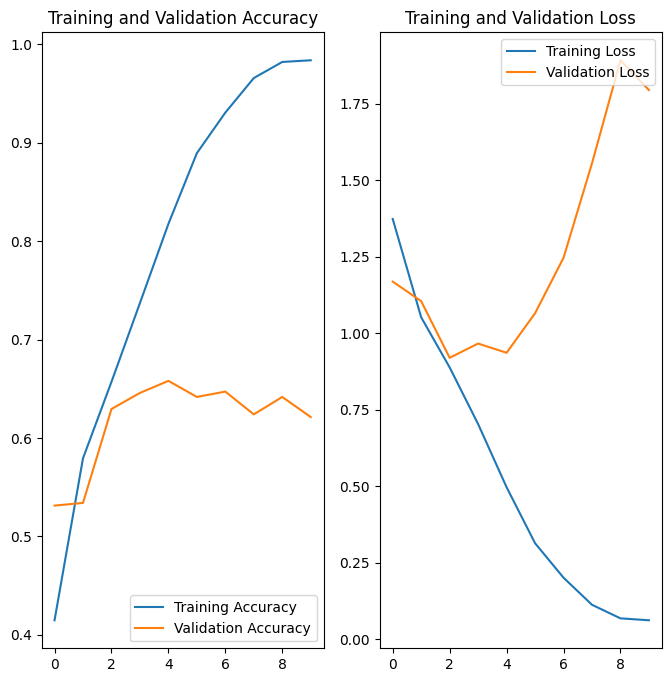

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

图表显示，训练准确率和验证准确率相差很大，并且模型在验证集上仅达到了 60% 左右的准确率。

以下教程部分展示了如何检查出了什么问题并尝试提高模型的整体性能。

## 过拟合

在上面的图表中，训练准确率随时间呈线性提升，而验证准确率在训练过程中停滞在 60% 左右。同时，训练准确率和验证准确率之间的差异也很明显，这是[过拟合](https://tensorflow.google.cn/tutorials/keras/overfit_and_underfit)的标志。

当训练样本数量较少时，模型有时会从训练样本中的噪声或不需要的细节中学习，以至于对模型在新样本上的性能产生负面影响。这种现象被称为过拟合。这意味着模型将很难在新数据集上泛化。

在训练过程中有多种方式解决过拟合问题。在本教程中，您将使用*数据增强*并将*随机失活*添加到模型中。

## 数据增强

过拟合通常会在训练样本数量较少的情况下发生。[数据增强](./data_augmentation.ipynb)采用的方法是：通过增强然后使用随机转换，从现有样本中生成其他训练数据，产生看起来可信的图像。这有助于向模型公开数据的更多方面，且有助于更好地进行泛化。

您将使用以下 Keras 预处理层实现数据增强：`tf.keras.layers.RandomFlip`、 `tf.keras.layers.RandomRotation` 和 `tf.keras.layers.RandomZoom`。这些层可以像其他层一样包含在您的模型中，并在 GPU 上运行。

In [22]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

通过对同一图像多次应用数据增强来呈现一些增强示例：

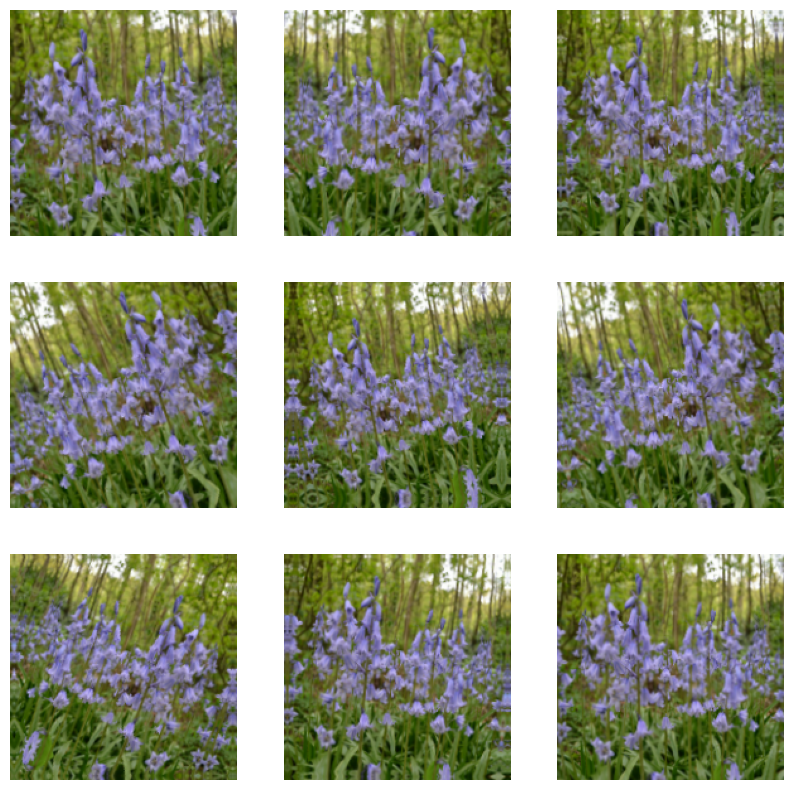

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

在下一步训练之前，您将在模型中添加数据增强。

## 随机失活

另一种减少过拟合的技术是向网络中引入[随机失活](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external}正则化。

将随机失活应用于层时，它会在训练过程中随机从该层丢弃（通过将激活设置为零）一些输出单元。随机失活会接受小数作为输入值，形式如 0.1、0.2、0.4 等。这意味着从应用了随机失活的层中随机丢弃 10%、20% 或 40% 的输出单元。

在使用增强图像对其进行训练之前，我们来使用 `tf.keras.layers.Dropout` 创建一个新的神经网络：

In [25]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## 编译并训练模型

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 13s 133ms/step - loss: 1.3922 - accuracy: 0.4084 - val_loss: 1.1140 - val_accuracy: 0.5436
Epoch 2/15
92/92 [==============================] - 12s 130ms/step - loss: 1.0858 - accuracy: 0.5627 - val_loss: 1.1769 - val_accuracy: 0.5640
Epoch 3/15
92/92 [==============================] - 12s 128ms/step - loss: 1.0147 - accuracy: 0.6042 - val_loss: 0.9950 - val_accuracy: 0.6022
Epoch 4/15
92/92 [==============================] - 12s 127ms/step - loss: 0.9064 - accuracy: 0.6529 - val_loss: 0.8566 - val_accuracy: 0.6553
Epoch 5/15
92/92 [==============================] - 12s 127ms/step - loss: 0.8402 - accuracy: 0.6805 - val_loss: 0.9138 - val_accuracy: 0.6553
Epoch 6/15
92/92 [==============================] - 12s 128ms/step - loss: 0.7773 - accuracy: 0.7074 - val_loss: 0.8319 - val_accuracy: 0.6798
Epoch 7/15
92/92 [==============================] - 12s 127ms/step - loss: 0.7527 - accuracy: 0.7119 - val_loss: 0.7926 - val_accuracy: 0.6907

## 呈现训练结果

应用数据增强和 `tf.keras.layers.Dropout` 后，过拟合的情况比以前少了，训练准确率和验证准确率也变得更为接近：

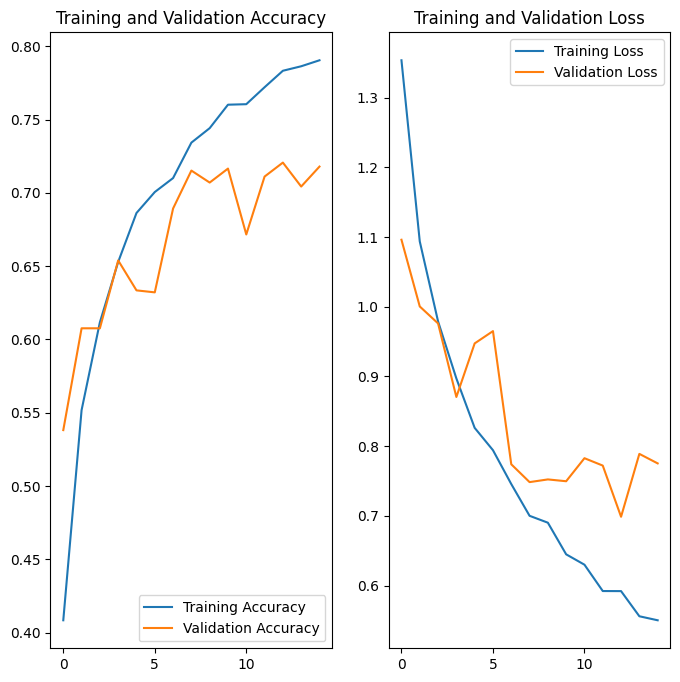

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 根据新数据进行预测

使用您的模型对一个未包含在训练集或验证集中的图像进行分类。

注：数据增强层和随机失活层在推断时处于非活动状态。

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


  8192/117948 [=>............................] - ETA: 0s


117948/117948 [==============================] - 0s 0us/step



1/1 [==============================] - ETA: 0s


1/1 [==============================] - 0s 276ms/step


This image most likely belongs to sunflowers with a 95.96 percent confidence.


## 实用 TensorFlow Lite

TensorFlow Lite 是一组工具，可帮助开发者在移动设备、嵌入式设备和边缘设备上运行模型，从而实现设备端机器学习。

### 将 Keras 序贯模型转换为 TensorFlow Lite 模型

要将经过训练的模型与设备端应用程序一起使用，请首先[将其转换](https://tensorflow.google.cn/lite/models/convert)为更小、更高效的模型格式，称为 [TensorFlow Lite](https://tensorflow.google.cn/lite/) 模型。

在此示例中，采用经过训练的 Keras 序贯模型并使用 `tf.lite.TFLiteConverter.from_keras_model` 生成 [TensorFlow Lite](https://tensorflow.google.cn/lite/) 模型：

In [31]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpi6vpsu/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpwpi6vpsu/assets


2023-11-07 22:59:11.894196: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-11-07 22:59:11.894246: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 11, Total Ops 23, % non-converted = 47.83 %
 * 11 ARITH ops

- arith.constant:   11 occurrences  (f32: 10, i32: 1)



  (f32: 3)
  (f32: 2)
  (f32: 3)
  (f32: 1)


您在上一步中保存的 TensorFlow Lite 模型可以包含多个函数签名。 Keras 模型转换器 API 会自动使用默认签名。详细了解 [TensorFlow Lite 签名](https://tensorflow.google.cn/lite/guide/signatures)。

### 运行 TensorFlow Lite 模型

您可以通过 `tf.lite.Interpreter` 类在 Python 中访问 TensorFlow Lite 保存的模型签名。

使用 `Interpreter` 加载模型：

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

打印转换后的模型中的签名以获得输入（和输出）的名称：


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

在此示例中，您有一个名为 `serving_default` 的默认签名。此外，`'inputs'` 的名称是 `'sequential_1_input'`，而 `'outputs'` 的名称为 `'outputs'`。如本教程前面所述，您可以在运行 `Model.summary` 时查找这些第一个和最后一个 Keras 层名称。

现在，您可以使用 `tf.lite.Interpreter.get_signature_runner` 通过传递签名名称对示例图像执行推断来测试加载的 TensorFlow 模型，如下所示：

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

与您在本教程前面所做的类似，您可以使用 TensorFlow Lite 模型对未包含在训练集或验证集中的图像进行分类。

您已经对该图像进行了张量化并将其保存为 `img_array`。现在，将其传递给已加载的 TensorFlow Lite 模型 (`predictions_lite`) 的第一个参数（`'inputs'` 的名称），计算 Softmax 激活，然后打印具有最高计算概率的类的预测。

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 95.96 percent confidence.


Lite 模型生成的预测应该与原始模型生成的预测几乎相同：

In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

1.4305115e-06


在 `'daisy'`、`'dandelion'`、`'roses'`、`'sunflowers'` 和 `'tulips'` 这五个类中，模型应该预测图像属于向日葵，这与 TensorFlow Lite 转换之前的结果相同。


## 后续步骤

本教程展示了如何训练用于图像分类的模型，对其进行测试，将其转换为 TensorFlow Lite 格式以用于设备端应用（例如图像分类应用），以及使用 Python API 通过 TensorFlow Lite 模型执行推断。

您可以通过[教程](https://tensorflow.google.cn/lite/tutorials)和[指南](https://tensorflow.google.cn/lite/guide)了解有关 TensorFlow Lite 的更多信息。